In [ ]:
from math import ceil
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import statsmodels.stats.api as sms

In [ ]:
# Calculating effect size based on our expected rates
effect_size = sms.proportion_effectsize(0.13, 0.15)

# Calculating sample size needed
required_n = sms.NormalIndPower().solve_power(
    effect_size,
    power = 0.8,  # Daya statistik yang diinginkan (80%)
    alpha = 0.05, # Tingkat signifikansi (5%)
    ratio = 1     # Rasio antara kelompok kontrol dan kelompok test
)
# Memastikan ukuran sampel selalu berupa bilangan bulat yang lebih tinggi
required_n = ceil(required_n)
# Menampilkan ukuran sampel yang diperlukan
print("Required sample size: ", required_n)

Required sample size:  4720


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Collection and preparing the data**

In [ ]:
df = pd.read_csv ('/content/drive/MyDrive/Colab Notebooks/Dataset/ab_data.csv')

In [ ]:
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [ ]:
session_counts = df['user_id'].value_counts(ascending = False)
multi_users = session_counts[session_counts > 1].count()

print(f"There are {multi_users} users that appear multiple times in the dataset")

There are 3894 users that appear multiple times in the dataset


In [ ]:
users_to_drop = session_counts[session_counts > 1].index

df = df[~df["user_id"].isin(users_to_drop)]
print(f"The updated dataset now has {df.shape[0]} entries")

The updated dataset now has 286690 entries


# **Sampling**

In [ ]:
from pandas.core.common import random_state
control_sample = df[df['group'] == 'control'].sample(n = required_n,
                                                     random_state = 123)
treatment_sample = df[df['group'] == 'treatment'].sample(n = required_n,
                                                         random_state = 123)
ab_test = pd.concat([control_sample, treatment_sample], axis = 0)
ab_test.reset_index(drop = True, inplace = True)

ab_test

,user_id,timestamp,group,landing_page,converted
0,689587,2017-01-13 11:17:53.637947,control,old_page,0
1,708802,2017-01-17 06:26:13.317907,control,old_page,0
2,734166,2017-01-09 03:16:50.487997,control,old_page,0
3,679205,2017-01-21 08:14:08.970343,control,old_page,0
4,664151,2017-01-10 09:55:59.891293,control,old_page,0
...,...,...,...,...,...
9435,716380,2017-01-15 20:46:06.462720,treatment,new_page,0
9436,756736,2017-01-13 16:10:39.545534,treatment,new_page,1
9437,828406,2017-01-07 17:31:42.889441,treatment,new_page,0
9438,715494,2017-01-13 19:17:29.879915,treatment,new_page,0


In [ ]:
ab_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9440 entries, 0 to 9439
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   user_id       9440 non-null   int64 
 1   timestamp     9440 non-null   object
 2   group         9440 non-null   object
 3   landing_page  9440 non-null   object
 4   converted     9440 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 368.9+ KB


In [ ]:
ab_test["group"].value_counts()

control      4720
treatment    4720
Name: group, dtype: int64

# **Visualize the results**

In [ ]:
conversion_rates = ab_test.groupby("group")["converted"]. \
    agg([np.mean, np.std, stats.sem])
conversion_rates.columns = ["conversion rate",
                            "std_deviation",
                            "std_error"]

conversion_rates

,conversion rate,std_deviation,std_error
group,,,
control,0.119068,0.323903,0.004715
treatment,0.119703,0.324649,0.004725


<ipython-input-21-32971265281e>:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  sns.barplot(x = ab_test['group'], y = ab_test['converted'], ci = False)


<Axes: xlabel='group', ylabel='converted'>

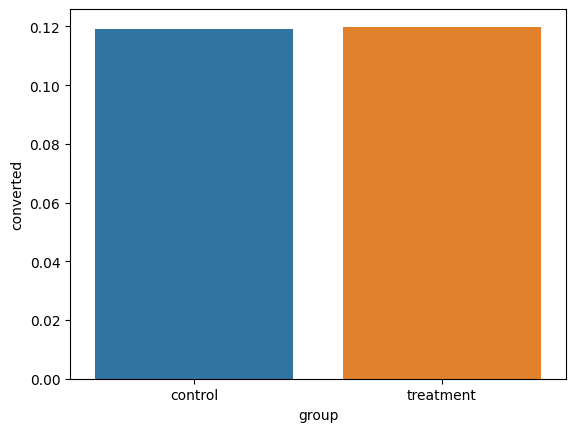

In [ ]:
sns.barplot(x = ab_test['group'], y = ab_test['converted'], ci = False)

# **Testing the hyphothesis**

In [ ]:
control_results = ab_test[ab_test['group'] == 'control']['converted']
control_results

0       0
1       0
2       0
3       0
4       0
       ..
4715    0
4716    0
4717    0
4718    0
4719    1
Name: converted, Length: 4720, dtype: int64

In [ ]:
treatment_results = ab_test[ab_test['group'] == 'treatment']['converted']
treatment_results

4720    1
4721    0
4722    0
4723    0
4724    0
       ..
9435    0
9436    1
9437    0
9438    0
9439    0
Name: converted, Length: 4720, dtype: int64

In [ ]:
n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs, alternative='two-sided')

print(f'z statistics: {z_stat}')
print(f'p-value: {pval}')

z statistics: -0.0952283816016755
p-value: 0.9241334271621442



---
Our ***p*-value = 0.924 Is way above a = 0.05 threshold**.

---

This means that we fail to reject the null hypothesis, which means that  

---

**our new design did not perform significantly different than our old one**.

Our ***p*-value = 0.924 Is way above a = 0.05 threshold**.
This means that we fail to reject the null hypothesis, which means that **our new design did not perform significantly different than our old one**.

# **Drawing conclusions**